# Intro to PySpark

An introduction to using pyspark to load data from `.csv` and psql database, as well as using SparkDataFrames and SQL to perform a query.

## Load necessary modules

In [1]:
from python.cca_schema import schema
from pyspark.sql.session import SparkSession
from matplotlib import pyplot as plt

## Create `spark` session object

In [3]:
# create spark session ----
spark = (
    SparkSession.builder
    # Sets the Spark master URL to connect to, such as "local" to run locally
    .master("local[1]")
    # Sets a name for the application, which will be shown in the Spark web UI
    .appName("Python Spark SQL example")
    # Gets an existing :class:SparkSession or, if there is no existing one,
    # creates a new one based on the options set in this builder
    .getOrCreate()
)

## Load necessary data

In [4]:
# load IL job data at the census block level
# note: IL job counts are from 2017
jobs_df = (
    spark.read
    .format("jdbc")
    .option("url", "jdbc:postgresql:///chicago")
    .option("dbtable", "il_wac_s000_jt00_2017")
    .load()
)

# load 2010 IL census block to 2010 IL census tract crosswalk data
xwalk_df = (
    spark.read
    .format("jdbc")
    .option("url", "jdbc:postgresql:///chicago")
    .option("dbtable", "il_xwalk")
    .load()
)

# load 2010 Chicago census tract data
ct_df = (
    spark.read
    .format("jdbc")
    .option("url", "jdbc:postgresql:///chicago")
    .option("dbtable", "census_tracts_2010")
    .load()
)

# load current Chicago community area data
cca_df = spark.read.csv(path="raw_data/community_areas.csv",
                        schema=schema,
                        sep=",",
                        header=False)  # header is supplied in schema


## Glimpse inside SparkDataFrame

In [5]:
cca_df.show(n=5, truncate=True, vertical=True)

-RECORD 0--------------------------
 the_geom   | null                 
 perimeter  | null                 
 area       | null                 
 comarea_   | null                 
 comarea_id | null                 
 area_numbe | null                 
 community  | null                 
 area_num_1 | null                 
 shape_area | null                 
 shape_len  | null                 
-RECORD 1--------------------------
 the_geom   | MULTIPOLYGON (((-... 
 perimeter  | 0                    
 area       | 0                    
 comarea_   | 0                    
 comarea_id | 0                    
 area_numbe | 35                   
 community  | DOUGLAS              
 area_num_1 | 35                   
 shape_area | 46004621.1581        
 shape_len  | 31027.0545098        
-RECORD 2--------------------------
 the_geom   | MULTIPOLYGON (((-... 
 perimeter  | 0                    
 area       | 0                    
 comarea_   | 0                    
 comarea_id | 0             

## Register SparkDataFrames as SQL views

In [6]:
jobs_df.createOrReplaceTempView("jobs")
xwalk_df.createOrReplaceTempView("xwalk")
ct_df.createOrReplaceTempView("ct")
cca_df.createOrReplaceTempView("cca")

## Count the number of jobs in each community area

### Layers of geography:

* many census blocks -> one census tract
* many census tracts -> one community area
* many community areas -> one City of Chicago

_note: 46826 blocks -> 801 tracts -> 77 community areas -> 1 city_

### Logic:

To do this, we need to mark the community area each Chicago census block resides in and then identify the number of jobs in each census block.

In [7]:
query = """
SELECT cca.community,
    SUM(jobs.c000) AS num_jobs
FROM xwalk
JOIN ct
    ON xwalk.trct = ct.geoid10
JOIN cca
    ON ct.commarea = cca.area_numbe
JOIN jobs
    ON xwalk.tabblk2010 = jobs.w_geocode
GROUP BY community
ORDER BY num_jobs DESC
"""

# execute query
jobs_cca = spark.sql(query)

# display results
jobs_cca.show(n=5, truncate=True, vertical=True)

-RECORD 0--------------------
 community | LOOP            
 num_jobs  | 437666          
-RECORD 1--------------------
 community | NEAR NORTH SIDE 
 num_jobs  | 192789          
-RECORD 2--------------------
 community | NEAR WEST SIDE  
 num_jobs  | 132880          
-RECORD 3--------------------
 community | OHARE           
 num_jobs  | 58669           
-RECORD 4--------------------
 community | WEST TOWN       
 num_jobs  | 46945           
only showing top 5 rows



## Convert to `pandas` DataFrame

In [8]:
# convert SparkDataFrame to Pandas DataFrame ----
jobs_cca_df = jobs_cca.toPandas()

jobs_cca_df.head()

,community,num_jobs
0,LOOP,437666
1,NEAR NORTH SIDE,192789
2,NEAR WEST SIDE,132880
3,OHARE,58669
4,WEST TOWN,46945


## Visualize Results

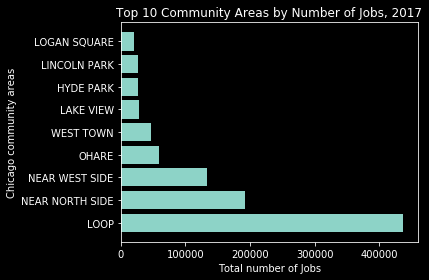

In [9]:
# visualize top ten CCAs by number of jobs ----
plt.barh(y=jobs_cca_df["community"][0:9],
         width=jobs_cca_df["num_jobs"][0:9])
plt.title("Top 10 Community Areas by Number of Jobs, 2017")
plt.xlabel("Total number of Jobs")
plt.ylabel("Chicago community areas")
plt.tight_layout()

# export plot as PNG ----
plt.savefig("visuals/top_ccas_by_jobs.png",
            dpi=200,
            bbox_inches="tight")

## Stop `spark` session

In [10]:
spark.stop()